![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import ast  # to convert strings to list
import re
from collections import Counter
import os
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/city-info/cities_info.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
40238,id_1731,London,"['European', 'British', 'Vegetarian Friendly',...",1734.0,$$ - $$$,155.0,"[['Great for drinks', 'Stunning London views &...",/Restaurant_Review-g186338-d11908107-Reviews-A...,d11908107,1,4.0
31899,id_13178,Paris,"['Chinese', 'Sushi']",13180.0,NaN,9.0,"[[], []]",/Restaurant_Review-g187147-d4598879-Reviews-Sa...,d4598879,1,3.5
529,id_529,Paris,"['French', 'Cafe', 'Vegetarian Friendly', 'Veg...",3364.0,$,57.0,[['Lovely small and cosy brunch place with de....,/Restaurant_Review-g187147-d7286031-Reviews-Le...,d7286031,0,0.0
22833,id_2171,Prague,['Asian'],2176.0,NaN,3.0,"[['Fantastic food must go', 'Huge servings, re...",/Restaurant_Review-g274707-d3669407-Reviews-Go...,d3669407,1,4.5
18466,id_2001,Prague,"['European', 'Czech']",2004.0,NaN,2.0,"[['Great Italian Joint'], ['05/26/2015']]",/Restaurant_Review-g274707-d7287638-Reviews-Vi...,d7287638,1,5.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [15]:
# посмотрим количество уникальных значений в каждом признаке
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

In [16]:
for i in data.columns:  # посмотрим более подробно типы данных
    print(i, type(data[i][1]))

Restaurant_id <class 'str'>
City <class 'str'>
Cuisine Style <class 'str'>
Ranking <class 'numpy.float64'>
Price Range <class 'str'>
Number of Reviews <class 'numpy.float64'>
Reviews <class 'str'>
URL_TA <class 'str'>
ID_TA <class 'str'>
sample <class 'numpy.int64'>
Rating <class 'numpy.float64'>


Итоги первичного обзора данных:
1. В объединенном датасете содержатся данные о 50000 ресторанов
2. Из изначальных 10 колонок имеем 3 количественных признака (Ranking, Number of reviews,Rating), остальные 7 - категориальные
3. 3 признака имеют значительное количество пропусков ('Cuisine Style','Price Range','Number of reviews') и признак 'review' имеет всего 2 пропуска в тестовой выборке
4. Ни один из признаков не может служить в качестве идеального уникального идентификатора
5. Признаки 'Reviews' и  'Cuisine Style' имеют строковый тип данных, однако могут быть преобразованы в списки данных

# Cleaning and Preparing Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [17]:
# cоздадим признаки, хранящие информацию о наличии пропуска в данных
# Чтобы новые признаки не мешались при использовании метода info сохраним их пока в отдельном датасете
data_nan = pd.DataFrame()
for i in ['Cuisine Style', 'Price Range', 'Number of Reviews']:
    data_nan[i.replace(" ", '_')+'_isNAN'] = pd.isna(data[i]).astype('uint8')
data_nan.sample(3)

,Cuisine_Style_isNAN,Price_Range_isNAN,Number_of_Reviews_isNAN
23058,0,0,0
2461,0,1,0
33526,0,1,0


Сами пропуски есть смысл заполнить после более подробного изучения признаков и их предобработки.
Возможно после визуализации и обработки появятся идеи как лучше заполнить пропуски.

## 2. Обработка признаков

Для начала рассмотрим и обработаем 7 категориальных признаков

### 1. Restaurant_id 

Пока непонятно какую информацию нам может дать этот признак. Но мы видим, что каждое значение состоит из одинаковой буквенной части и числовой. Пользу нам может принести только вторая часть, поэтому оставим только её.

In [18]:
data.Restaurant_id = data.Restaurant_id.apply(lambda x: int(x[3:]))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null int64
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(2), object(6)
memory usage: 4.2+ MB


### 2. ID_TA

Здесь как и в Restaurant_id есть буквенная "d" и числовая часть - выделим числовую.

In [19]:
data.ID_TA = data.ID_TA.apply(lambda x: int(x[1:]))

In [20]:
# Мы уже обратили внимание, что данный признак содержит неуникальные записи, найдём такие записи и посмотрим на них
#data['is_double']=data['ID_TA'].apply(lambda x:0 if data[data.ID_TA==x].ID_TA.count()==1 else 1)
# data[data.is_double==1].sort_values(['ID_TA']).head(6)

Кажется, мы столкнулись с дубликатами. Но! При этом ranking у таких записей разный, причём где-то ощутимо. Не понятно,что делать с этими записями : их всего 37 и самый очевидный вариант удалить. Но какую из пары выбросить?

Больша часть проблемных записей сосредоточилась в Мадриде. При этом есть записи которые попали в разные выборки. Причина такого задвоения нам не известна. 

### 3. URL_TA
В данном признаке содержится информация:
1. URL_TA ресторана, количество задвоений такое же как и для признака URL_TA
2. Признак вида g187147 - как выяснилось это символ города
3. Название ресторана - в перспективе можно попробовать поискать наименования известных сетей и вытащить признаки принадлежности к ним

In [21]:
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0


### 4. City

In [22]:
# создадим датасет с информацией о городах
cities = data.City.value_counts().reset_index()
cities.columns = ['City', 'number_of_rest']
cities

,City,number_of_rest
0,London,7193
1,Paris,6108
2,Madrid,3813
3,Barcelona,3395
4,Berlin,2705
5,Milan,2694
6,Rome,2589
7,Prague,1816
8,Lisbon,1647
9,Vienna,1443


Мы видим, что в датасете представлен 31 город, все города находятся в Европе, достаточно крупные и с хорошим туристическим потенциалом. На основе данных о городе можно создать новые признаки, используя словари или внешние датасеты. 
Соберем её предварительно в датасете о городах а потом перенесём в основной датасет.
Из информации о городе мы можем получить такие признаки:

* 4.1 number_of_rest : Количество ресторанов в городе
* 4.2 Population : Население города
* 4.3 Visitors: Количество туристов, приезжающих в город за год
* 4.4 is_capital: Столица или нет
* 4.5 Coutry: Страна 

Для показателя 4.1 мы уже воспользовались Value_counts, для 4.2 - 4.5 подгрузим внешний датасет с информацие про города

In [23]:
# подгружаем внешний датасет
city_stat = pd.read_csv('/kaggle/input/city-info/cities_info.csv', sep=";")
city_stat.sample()

,City,Population,Visitors,Is_capital,Country
4,Munich,"1,471","8,8",0,Germany


In [24]:
# перенесём данные из внешнего датасета в наш датасет с городами
cities = pd.merge(cities, city_stat, on='City')
cities['Population'] = cities['Population'].apply(lambda x: float(
    x.replace(',', '.')))  # приведём исходные данные в корректный вид
cities['Visitors'] = cities['Visitors'].apply(lambda x: float(
    x.replace(',', '.')))  # приведём исходные данные в корректный вид
cities.sample()

,City,number_of_rest,Population,Visitors,Is_capital,Country
0,London,7193,8.2,26.3,1,England


In [25]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
City              31 non-null object
number_of_rest    31 non-null int64
Population        31 non-null float64
Visitors          31 non-null float64
Is_capital        31 non-null int64
Country           31 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 1.7+ KB


In [26]:
# Создадим ещё несколько параметров на основе выше полученных
cities['rest_per_mil_people'] = cities['number_of_rest'] / \
    cities['Population']  # количество ресторанов на миллион жителей
cities['rest_per_mil_visitor'] = cities['number_of_rest'] / \
    cities['Visitors']  # количество ресторанов на миллион посетиттелей в год
# cities.sample()

In [27]:
# Теперь добавим новые параметры из датасета про города в основной датасет
data = data.merge(cities, how="left").set_index(data.index)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
Restaurant_id           50000 non-null int64
City                    50000 non-null object
Cuisine Style           38410 non-null object
Ranking                 50000 non-null float64
Price Range             32639 non-null object
Number of Reviews       46800 non-null float64
Reviews                 49998 non-null object
URL_TA                  50000 non-null object
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
number_of_rest          50000 non-null int64
Population              50000 non-null float64
Visitors                50000 non-null float64
Is_capital              50000 non-null int64
Country                 50000 non-null object
rest_per_mil_people     50000 non-null float64
rest_per_mil_visitor    50000 non-null float64
dtypes: float64(7), int64(5), object(6)
memory usage: 6.9+ MB

### 5. Cuisine Style
Для начала заполним пропуски в кухнях. Заменим отсутствующие на значение 'no_info'

In [29]:
data["Cuisine Style"].fillna("['no_info']", inplace=True)

In [30]:
#Добавим новый признак среднее количество кухонь для ресторана
data["Cuisine Style"] = data["Cuisine Style"].apply(lambda x: ast.literal_eval(x)) #используем ast для получения списка для каждого ресторана
data['cuisine_number']=data["Cuisine Style"].apply(lambda x: len(x)) 
cuisine_list = [item for sublist in data["Cuisine Style"] for item in sublist] # создаём единый список кухонь
cuisine_style_counter = Counter(cuisine_list) #посчитаем как часто встречается та или иная кухня
cuisine_style_counter.most_common(20) #посмотрим на топ 20 самых популяпных

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('no_info', 11590),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727)]

In [31]:
# Создадим бинарные признаки на основе кухонь и поместим их в отдельную базу
mlb = MultiLabelBinarizer()
encoded_cuisine = pd.DataFrame(mlb.fit_transform(data['Cuisine Style']),
                               columns=mlb.classes_, index=data.index)
encoded_cuisine

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,no_info
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
49996,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [32]:
# как мы видим в датасете представлено 126 разных видов кухонь, однако не все
# признаки будут полезны, поэтому оставим 45 самых популярных
top_cuisine = [x[0] for x in cuisine_style_counter.most_common(45)]
encoded_cuisine = encoded_cuisine[top_cuisine]

### 6. Price Range

In [33]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

О данном признаке можно сказать следующее:
* Данный признак содержит очень много пропусков : избавимся от них, заменив на самое популряное значение
* Данный признак содержит небольшой диапазон возможных значений и их можно ранжировать, значит перед нами ординальный признак и для него отлично подойдёт такое преобразование как label encoding

In [34]:
data['Price Range'].fillna("$$ - $$$", inplace=True)  # заполняем пропуски
price_range_dict = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3
}

data['Price Range'] = data['Price Range'].map(price_range_dict)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
Restaurant_id           50000 non-null int64
City                    50000 non-null object
Cuisine Style           50000 non-null object
Ranking                 50000 non-null float64
Price Range             50000 non-null int64
Number of Reviews       46800 non-null float64
Reviews                 49998 non-null object
URL_TA                  50000 non-null object
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
number_of_rest          50000 non-null int64
Population              50000 non-null float64
Visitors                50000 non-null float64
Is_capital              50000 non-null int64
Country                 50000 non-null object
rest_per_mil_people     50000 non-null float64
rest_per_mil_visitor    50000 non-null float64
cuisine_number          50000 non-null int64
dtypes: float64(7

### 7. Reviews
В данном столбце по сути содержится 4 разных признака. Прежде чем вытащить их заполним пропуски: 2 пропуска, которые есть в тестовой выборке и те случаи когда вместо одного из 4х значений в строке стоит nan

In [35]:
data["Reviews"] = data["Reviews"].str.replace("nan", "' '")
data["Reviews"].fillna("[[], []]", inplace=True)

In [36]:
# Теперь преобразуем в списки и создадим 3 новые переменные для текста и 2х дат
data["Reviews"] = data["Reviews"].apply(
    lambda x: ast.literal_eval(x))  # преобразуем в списки
data["review_text"] = data["Reviews"].apply(
    lambda x: str(x[0])[1:-1].split(','))
data["review_date1"] = data["Reviews"].apply(
    lambda x: ("" if str(x[1])[1:-1] == "" else x[1][0]))
data["review_date2"] = data["Reviews"].apply(lambda x: (
    "" if str(x[0])[1:-1] == "" else ("" if len(x[1]) < 2 else x[1][1])))
# Преобразуем даты в Datetime формат
data["review_date1"] = pd.to_datetime(data["review_date1"])
data["review_date2"] = pd.to_datetime(data["review_date2"])
# Сохраним информацию о пропусках в датах
for i in ["review_date1", "review_date1"]:
    data_nan[i.replace(" ", '_')+'_isNAN'] = pd.isna(data[i]).astype('uint8')

In [37]:
# посчитаем даты самого свежего и самого старого отзыва
max_date = pd.concat(
    [data["review_date1"], data["review_date1"]]).dropna().max()
min_date = pd.concat(
    [data["review_date1"], data["review_date1"]]).dropna().min()
# Заполним пропуски в датах
# заполним пустые значения самым ранним
data["review_date1"].fillna(min_date, inplace=True)
# заполним пустые значения 2й даты значением 1й
data.loc[pd.isnull(data['review_date2']),
         'review_date2'] = data['review_date1']

In [38]:
# Теперь попробуем из дат извлечь новые признаки
# разница между отзывами
data["review_gap"] = (data['review_date1'] - data['review_date2']).dt.days
data['time_to_max'] = (max_date - data['review_date1']).dt.days

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
Restaurant_id           50000 non-null int64
City                    50000 non-null object
Cuisine Style           50000 non-null object
Ranking                 50000 non-null float64
Price Range             50000 non-null int64
Number of Reviews       46800 non-null float64
Reviews                 50000 non-null object
URL_TA                  50000 non-null object
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
number_of_rest          50000 non-null int64
Population              50000 non-null float64
Visitors                50000 non-null float64
Is_capital              50000 non-null int64
Country                 50000 non-null object
rest_per_mil_people     50000 non-null float64
rest_per_mil_visitor    50000 non-null float64
cuisine_number          50000 non-null int64
review_text      

Теперь поработаем с текстами отзывов, которые мы поместили в review_text. Сначала создадим большой список всех слов, которые используются в отзывах.

In [39]:
word_list = [item for row in data["review_text"]
             for item in row for item in item.replace("'", "").split(' ')]
word_list = list(map(lambda x: x.lower().replace(
    "!", "").replace('?', ""), word_list))

In [40]:
# Создадим датафрейм с информацией о словах и их частоте в отзывах
review_word_counter = Counter(word_list).most_common()
review_word_counter
review_words = pd.DataFrame(review_word_counter, columns=['word', 'freq'])

In [41]:
# Создадим списки слов:
# частые слова, которые не принесут нам пользы
service_words = ["", "-", "i", "we", "you", "all", "a", "an", "and", "&", "in",
                 "the", "for", "to", "of", "with", "but", "as", "it", "is", "on", "at", 'food']
# частые слова выражающие позитивное отношение
# positive_words = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'lovely', 'amazing', 'tasty', 'friendly', 'beautiful',
#                'well', 'top', 'awesome', 'fantastic', 'quick', 'perfect', 'wonderful', 'favourite', 'worth', 'yummy', 'decent', 'super']
positive_words = ['good', 'great', 'nice', 'best', 'excellent', 'delicious', 'lovely', 'amazing', 'tasty', 'friendly', 'beautiful',
                  'well', 'top', 'awesome', 'fantastic', 'quick', 'perfect', 'wonderful', 'favourite', 'worth', 'yummy']
# частые слова выражающие негативно отношение
negative_words = ['poor', 'worst', 'terrible', 'disappointing',
                  'slow', 'overpriced', 'rude', 'bad']
# добавим в датасет со словами информацию о характере слов
review_words['mood'] = review_words['word'].apply(lambda x:
                                                  "positive" if x in positive_words else ('negative' if x in negative_words else('serv' if x in service_words else 'other')))
review_words['freq_share'] = review_words['freq'] / \
    review_words['freq'].sum()*100
# Посмотрим на все слова с оттенком отношения, которые мы выделили
review_words[(review_words.mood != 'other') & (review_words.mood != 'serv')]

,word,freq,mood,freq_share
2,good,11569,positive,3.140098
3,great,10509,positive,2.852389
8,nice,5639,positive,1.530557
14,best,3280,positive,0.890269
15,excellent,3201,positive,0.868826
21,delicious,2119,positive,0.575146
23,friendly,1847,positive,0.501319
24,lovely,1760,positive,0.477705
25,amazing,1733,positive,0.470377
27,tasty,1647,positive,0.447034


In [42]:
word_encoded = pd.DataFrame(index=data.index)
word_encoded['positive'] = 0


def word_dummy(word_list):
    for word in word_list:
        word_encoded[word+'_in_rev'] = \
            data['review_text'].apply(
                lambda x: 0 if str(x).find(word) == -1 else 1)

        if word in positive_words:
            word_encoded['positive'] = \
                word_encoded['positive']+word_encoded[word+'_in_rev']
        # elif word in negative_words:
            # word_encoded['negative'] = \
            # pd.to_numeric(word_encoded['negative']+word_encoded[word+'_in_rev'])


word_dummy(positive_words)
word_dummy(negative_words)
word_encoded

,positive,good_in_rev,great_in_rev,nice_in_rev,best_in_rev,excellent_in_rev,delicious_in_rev,lovely_in_rev,amazing_in_rev,tasty_in_rev,...,worth_in_rev,yummy_in_rev,poor_in_rev,worst_in_rev,terrible_in_rev,disappointing_in_rev,slow_in_rev,overpriced_in_rev,rude_in_rev,bad_in_rev
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Теперь перейдём к рассмотрению количественных признаков

### 8. Number of reviews

Для начала избавимся от пропусков

In [43]:
data['Number of Reviews'].fillna(1, inplace=True)

# EDA 
Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.


### Посмотрим распределение признака

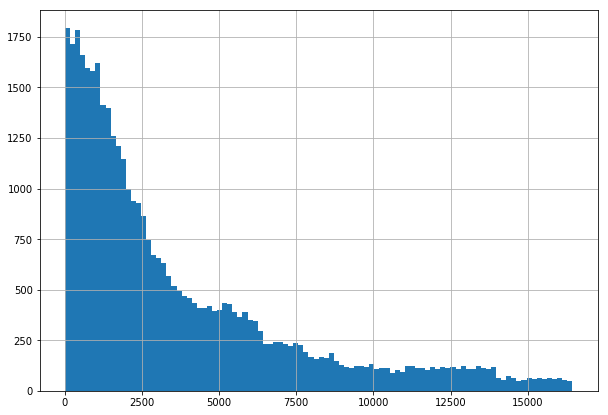

In [44]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

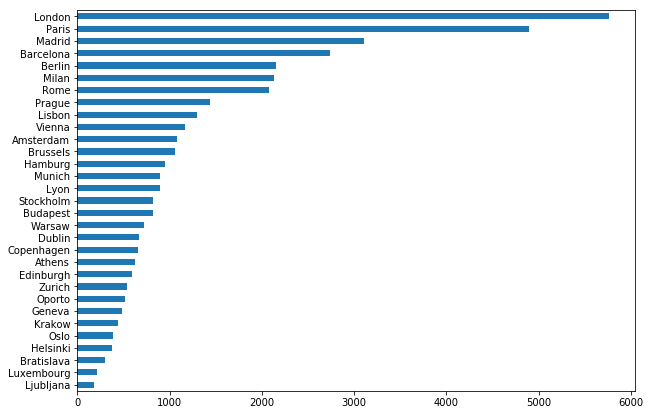

In [45]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

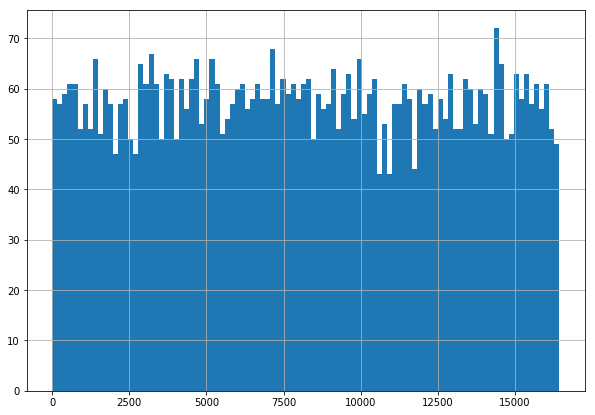

In [46]:
df_train['Ranking'][df_train['City'] == 'London'].hist(bins=100)

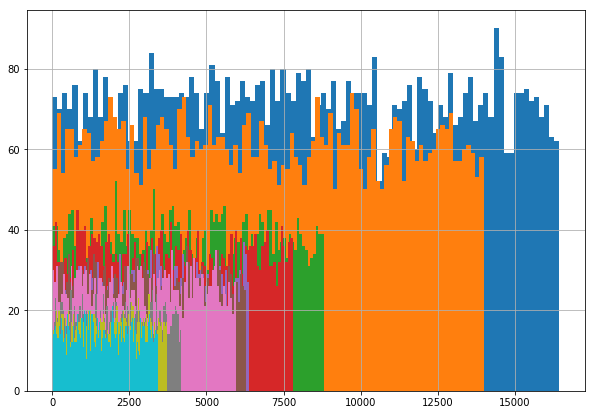

In [47]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

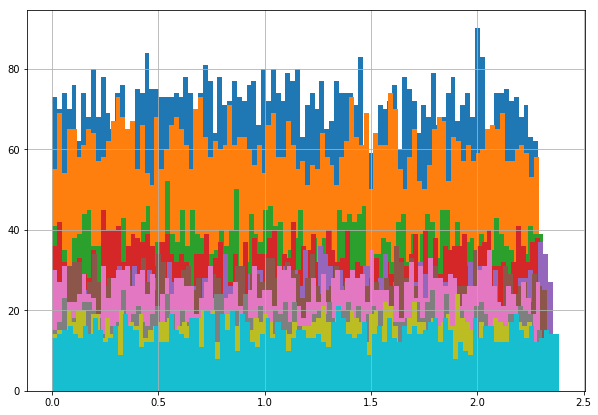

In [48]:
# Признак необходимо нормализовать, введём новый параметр относительный рейтинг
data['Rel_Ranking'] = data['Ranking'] / data['number_of_rest']
for x in (data['City'].value_counts())[0:10].index:
    data['Rel_Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

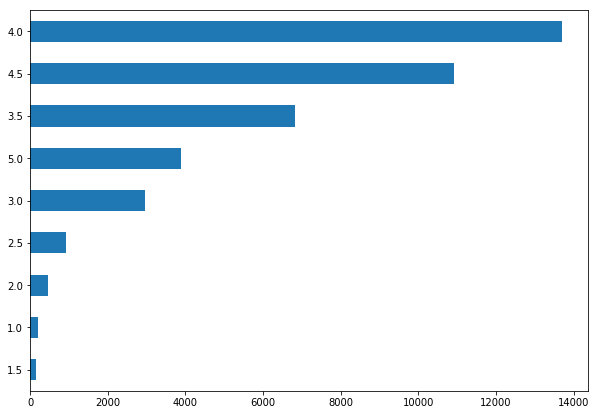

In [49]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

все значения в границах допустимых значений, выбросов нет. Также видим что все значения округляются до 0.5. Это значит что в дальнейшем нам нужно будет привести наш предсказанный рейтинг к такому же виду.

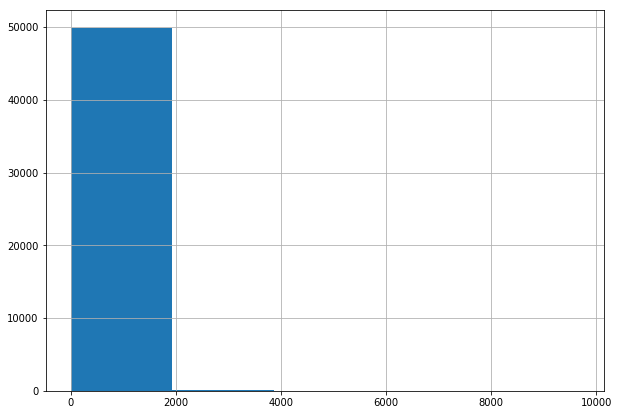

In [50]:
data['Number of Reviews'].hist(bins=5)

In [51]:
# Посмотрим на несколько очень больших значений
data[data['Number of Reviews'] > 4000]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Country,rest_per_mil_people,rest_per_mil_visitor,cuisine_number,review_text,review_date1,review_date2,review_gap,time_to_max,Rel_Ranking
44,44,Edinburgh,"[Seafood, European, British, Soups, Scottish, ...",266.0,3,4567.0,"[[Come for the wine more than the food, Desser...",/Restaurant_Review-g186525-d720945-Reviews-The...,720945,0,...,Scotland,1526.639344,227.828746,7,"['Come for the wine more than the food', 'Des...",2018-01-11,2018-01-05,6,46,0.357047
216,216,Barcelona,"[Seafood, Mediterranean, European, Spanish, So...",981.0,2,4996.0,"[[Great place, locals go here to eat..., Nice ...",/Restaurant_Review-g187497-d717275-Reviews-La_...,717275,0,...,Spain,2095.679012,175.997926,7,"['Great place, locals go here to eat...', 'N...",2018-01-07,2018-01-06,1,50,0.288954
1158,1158,Prague,"[American, Bar, European, Central American, Ve...",183.0,2,4382.0,"[[NYE, Good food, not as expensive as mentione...",/Restaurant_Review-g274707-d1516182-Reviews-Ha...,1516182,0,...,Check Republic,1513.333333,383.122363,6,"['NYE', 'Good food, not as expensive as ment...",2018-01-04,2018-01-04,0,53,0.100771
1369,1369,Rome,"[Pizza, Italian, Vegetarian Friendly, Vegan Op...",95.0,2,5037.0,[[Best dinner we had in Italy and in our ent.....,/Restaurant_Review-g187791-d3666269-Reviews-Da...,3666269,0,...,Italy,941.454545,429.139731,5,['Best dinner we had in Italy and in our ent.....,2018-01-07,2018-01-07,0,50,0.036694
2550,2550,London,"[British, French, European, Vegetarian Friendl...",274.0,3,5011.0,"[[Lovely chilled lunch, Birthday Lunch], [01/0...",/Restaurant_Review-g186338-d776287-Reviews-The...,776287,0,...,England,877.195122,273.498099,6,"['Lovely chilled lunch', 'Birthday Lunch']",2018-01-08,2018-01-08,0,49,0.038093
4166,4166,Krakow,"[Polish, European, Eastern European, Central E...",106.0,2,4608.0,"[[Traditional fayre - huge portions, good at.....",/Restaurant_Review-g274772-d1009022-Reviews-Po...,1009022,0,...,Poland,720.416125,39.571429,4,"['Traditional fayre - huge portions, good at....",2018-01-04,2018-01-04,0,53,0.191336
4952,4952,Budapest,"[European, Central European, Hungarian, Vegeta...",40.0,2,4977.0,"[[Brilliant lunch, Worth to visit for locals],...",/Restaurant_Review-g274887-d4041036-Reviews-Ze...,4041036,0,...,Hungary,593.604651,395.736434,5,"['Brilliant lunch', 'Worth to visit for locals']",2018-01-07,2018-01-04,3,50,0.039177
5295,5295,Brussels,"[French, Belgian, Seafood, European]",189.0,2,6437.0,"[[Interesting restaurant, not sure of the fu.....",/Restaurant_Review-g188644-d694788-Reviews-Che...,694788,0,...,Belgium,8212.500000,365.000000,4,"['Interesting restaurant, not sure of the fu....",2018-02-25,2018-02-23,2,1,0.143836
12752,79,Prague,"[International, European, Czech, Cafe, Soups, ...",80.0,2,4521.0,"[[A touch of glamour, Don't miss seeing this p...",/Restaurant_Review-g274707-d1118146-Reviews-Ca...,1118146,1,...,Check Republic,1513.333333,383.122363,10,"['A touch of glamour', ""Don't miss seeing thi...",2018-01-09,2018-01-07,2,48,0.044053
14817,144,Rome,"[Italian, Mediterranean, European, Vegetarian ...",145.0,2,5927.0,"[[Incredible food!, That is a more :-)], [01/0...",/Restaurant_Review-g187791-d1207928-Reviews-Th...,1207928,1,...,Italy,941.454545,429.139731,5,"['Incredible food!', 'That is a more :-)']",2018-01-09,2018-01-07,2,48,0.056006


Данные с большим количеством отзывов немногочисленны и вряд ли являются ошибочными, просто их немного. Приведём значения больше 4000 к 4000.

In [52]:
data['Number of Reviews'] = data['Number of Reviews'].apply(
    lambda x: 4000 if x > 4000 else x)

### Посмотрим распределение целевой переменной относительно признака

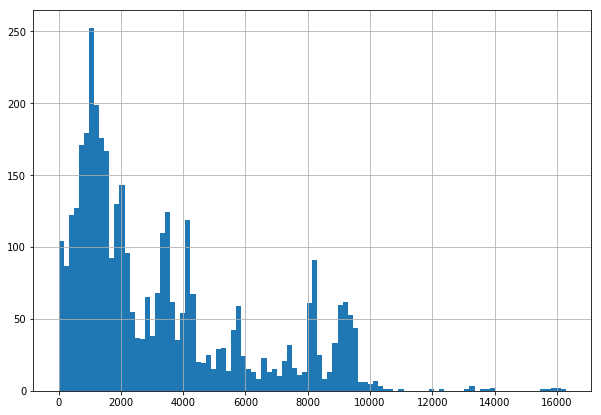

In [53]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

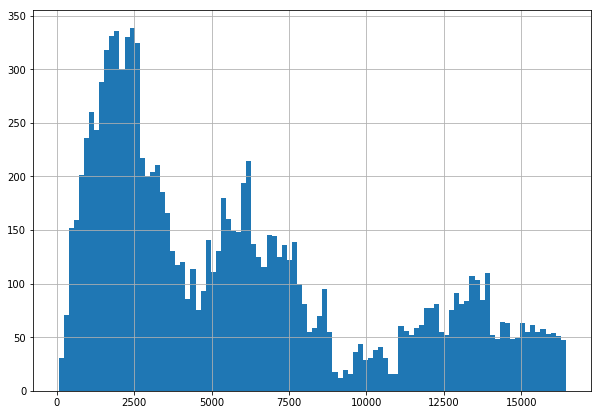

In [54]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### корреляция признаков

На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

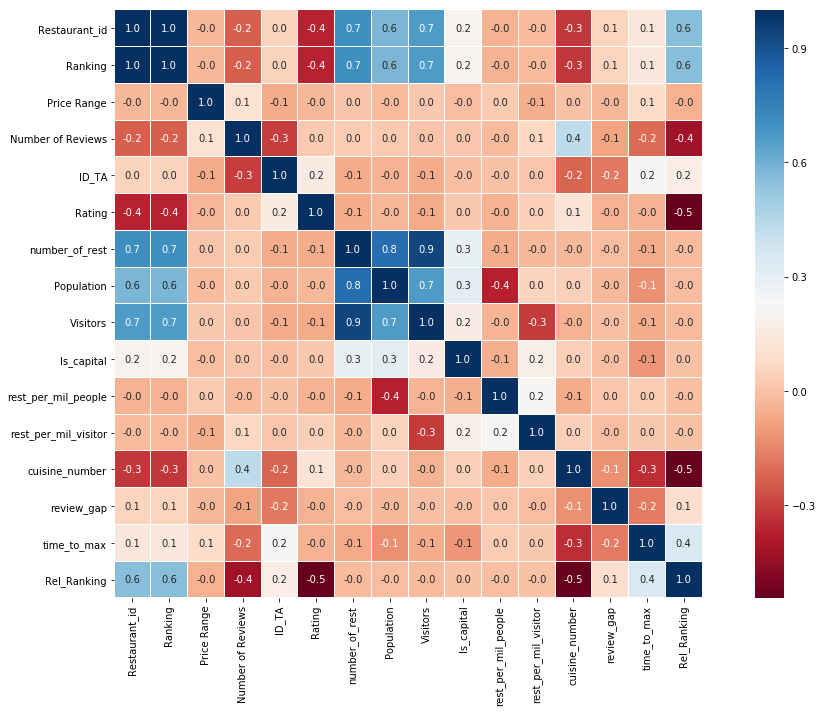

In [55]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(data[data['sample'] == 1].drop(['sample'], axis=1).corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")
plt.tight_layout()

Мы видим, что наиболее высокую корреляцию целевая переменная имеет с признаком Ranking, Rel_Ranking и Restaurant_ID,что в принципе логично. Так как Restaurant_ID имеет коэффициент корреляции с Rel_Ranking равный 1, имеет смысл избавить от этого признака. Дополнительной пользы он нам не принесёт.

# Data Preprocessing


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
Restaurant_id           50000 non-null int64
City                    50000 non-null object
Cuisine Style           50000 non-null object
Ranking                 50000 non-null float64
Price Range             50000 non-null int64
Number of Reviews       50000 non-null float64
Reviews                 50000 non-null object
URL_TA                  50000 non-null object
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
number_of_rest          50000 non-null int64
Population              50000 non-null float64
Visitors                50000 non-null float64
Is_capital              50000 non-null int64
Country                 50000 non-null object
rest_per_mil_people     50000 non-null float64
rest_per_mil_visitor    50000 non-null float64
cuisine_number          50000 non-null int64
review_text      

In [57]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na

data = pd.get_dummies(data, columns=['City'], dummy_na=False)
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
# Избавимся от дат, мы уже получили из них, что могли
data.drop('review_date1', axis=1, inplace=True)
data.drop('review_date2', axis=1, inplace=True)
# Избавимся от нечисловых колонок
data.drop(object_columns, axis=1, inplace=True)
# Избавимся от признака с высокой корреляцией
data.drop('Restaurant_id', axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 47 columns):
Ranking                 50000 non-null float64
Price Range             50000 non-null int64
Number of Reviews       50000 non-null float64
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
number_of_rest          50000 non-null int64
Population              50000 non-null float64
Visitors                50000 non-null float64
Is_capital              50000 non-null int64
rest_per_mil_people     50000 non-null float64
rest_per_mil_visitor    50000 non-null float64
cuisine_number          50000 non-null int64
review_gap              50000 non-null int64
time_to_max             50000 non-null int64
Rel_Ranking             50000 non-null float64
City_Amsterdam          50000 non-null uint8
City_Athens             50000 non-null uint8
City_Barcelona          50000 non-null uint8
City_Berlin         

In [58]:
# Добавляем созданные раннее dummy - переменные
data = pd.concat([data, word_encoded], axis=1)
data = pd.concat([data, data_nan], axis=1)
data = pd.concat([data, encoded_cuisine], axis=1)
data.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 126 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
ID_TA                      50000 non-null int64
sample                     50000 non-null int64
Rating                     50000 non-null float64
number_of_rest             50000 non-null int64
Population                 50000 non-null float64
Visitors                   50000 non-null float64
Is_capital                 50000 non-null int64
rest_per_mil_people        50000 non-null float64
rest_per_mil_visitor       50000 non-null float64
cuisine_number             50000 non-null int64
review_gap                 50000 non-null int64
time_to_max                50000 non-null int64
Rel_Ranking                50000 non-null float64
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barce

#### Запускаем и проверяем что получилось

In [59]:
df_preproc = data
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,number_of_rest,Population,Visitors,Is_capital,...,Barbecue,Contemporary,Soups,Eastern European,Vietnamese,Grill,Gastropub,Turkish,Mexican,South American
20352,1204.0,2,17.0,10626952,1,4.0,819,0.51,7.580,1,...,0,0,0,0,1,0,0,0,0,0
31855,8700.0,2,19.0,8822354,1,3.5,6108,2.23,28.000,1,...,0,0,0,0,0,0,0,0,0,0
31330,810.0,2,730.0,2184987,1,4.0,7193,8.20,26.300,1,...,0,0,0,0,0,0,1,0,0,0
7143,2755.0,2,38.0,10339666,0,0.0,2589,2.75,6.033,1,...,0,0,0,0,0,0,0,0,0,0
21036,1828.0,2,5.0,7375924,1,4.0,1033,0.81,10.000,1,...,0,0,0,0,0,0,0,0,0,0
38088,2777.0,2,16.0,4596790,1,4.0,1816,1.20,4.740,1,...,0,0,0,0,0,0,0,0,0,0
29056,860.0,2,33.0,8319732,1,4.5,1647,0.49,3.000,1,...,0,0,0,0,0,0,0,0,0,0
37350,12229.0,2,19.0,12973646,1,3.5,7193,8.20,26.300,1,...,0,0,0,0,0,0,0,0,0,0
42128,1029.0,2,42.0,9464696,1,4.5,2705,3.44,8.260,1,...,0,0,0,0,0,0,0,0,0,0
48269,7441.0,2,195.0,3220475,1,3.5,6108,2.23,28.000,1,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df_preproc.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 126 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
ID_TA                      50000 non-null int64
sample                     50000 non-null int64
Rating                     50000 non-null float64
number_of_rest             50000 non-null int64
Population                 50000 non-null float64
Visitors                   50000 non-null float64
Is_capital                 50000 non-null int64
rest_per_mil_people        50000 non-null float64
rest_per_mil_visitor       50000 non-null float64
cuisine_number             50000 non-null int64
review_gap                 50000 non-null int64
time_to_max                50000 non-null int64
Rel_Ranking                50000 non-null float64
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barce

In [61]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [62]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 125), (40000, 125), (40000, 124), (32000, 124), (8000, 124))

# Model 
Сам ML

In [64]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [65]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [66]:
# напишем функцию для округления рейтинга
def rating_round(rating_array):
    return np.array([0.5 * round(x/0.5) for x in rating_array])

In [67]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = rating_round(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [68]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
MAE_previous = 0.1638125
MAE_boost = MAE_previous-metrics.mean_absolute_error(y_test, y_pred)
MAE_boost

MAE: 0.1638125


0.0

['Rel_Ranking',
 'Number of Reviews',
 'City_Rome',
 'Ranking',
 'ID_TA',
 'time_to_max',
 'review_gap',
 'Visitors',
 'rest_per_mil_people',
 'rest_per_mil_visitor',
 'City_Madrid',
 'cuisine_number',
 'Population',
 'number_of_rest',
 'City_Amsterdam',
 'Number_of_Reviews_isNAN',
 'Price Range',
 'Price_Range_isNAN',
 'City_Edinburgh',
 'positive']

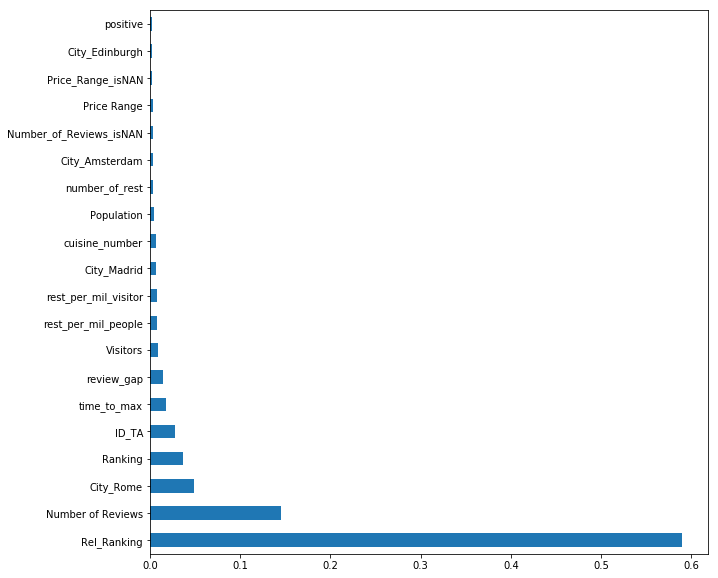

In [69]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
list(feat_importances.nlargest(20).reset_index()['index'])

# Submission
Если все устраевает - готовим Submission на кагл

In [70]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,ID_TA,Rating,number_of_rest,Population,Visitors,Is_capital,rest_per_mil_people,...,Barbecue,Contemporary,Soups,Eastern European,Vietnamese,Grill,Gastropub,Turkish,Mexican,South American
7380,1361.0,3,107.0,1079743,0.0,3395,1.620,19.290,0,2095.679012,...,0,0,0,0,0,0,0,0,0,0
8618,8745.0,2,82.0,8521832,0.0,7193,8.200,26.300,1,877.195122,...,0,0,0,0,0,0,0,0,0,0
5173,3592.0,2,86.0,1418269,0.0,3395,1.620,19.290,0,2095.679012,...,0,0,0,0,0,0,0,0,0,0
954,1987.0,2,81.0,10730566,0.0,1021,1.720,2.580,1,593.604651,...,0,0,0,0,0,0,0,0,0,0
1683,1178.0,2,3.0,2209686,0.0,1033,0.810,10.000,1,1275.308642,...,0,0,0,0,0,0,0,0,0,0
7843,371.0,2,97.0,8719996,0.0,1126,0.506,6.000,0,2225.296443,...,0,0,0,0,0,0,0,0,0,0
4339,965.0,1,137.0,8448397,0.0,2589,2.750,6.033,1,941.454545,...,0,0,0,0,0,0,0,0,0,0
2674,5193.0,2,2.0,12946550,0.0,2589,2.750,6.033,1,941.454545,...,0,0,0,0,0,0,0,0,0,0
6779,5495.0,2,14.0,12213859,0.0,2589,2.750,6.033,1,941.454545,...,0,0,0,0,0,0,0,0,0,0
7968,1651.0,2,38.0,10121012,0.0,3813,3.200,14.000,1,1191.562500,...,0,0,0,0,0,0,0,0,0,0


In [71]:
test_data = test_data.drop(['Rating'], axis=1)

In [72]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [73]:
predict_submission = rating_round(model.predict(test_data))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [74]:
predict_submission

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [75]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
